### Obtain and inspect Landschutzer climatology

https://www.nodc.noaa.gov/ocads/oceans/SPCO2_1982_2015_ETH_SOM_FFN.html

The observation-based pCO2 fields were created using a 2-step neural network method extensively described and validated in Landschützer et al. 2013, 2014, 2016. The method first clusters the global ocean into biogeochemical provinces and in a second step reconstructs the non-liner relationship between CO2 driver variables and observations from the 4th release of the Surface Ocean CO2 Atlas (SOCATv4, Bakker et al. 2016). This file contains the resulting monthly pCO2 fields at 1°x1° resolution covering the global ocean with the exception of the Arctic Ocean and few marginal seas. The air-sea CO2 fluxes are computed from the air-sea CO2 partial pressure difference and a bulk gas transfer formulation following Landschützer et al. 2013, 2014, 2016. Furthermore, the monthly climatology is created from the monthly average of the period 1985-2015.

This product is free to be used. Please cite this data set as:

Landschützer, P., N. Gruber and D.C.E. Bakker (2017). An updated observation-based global monthly gridded sea surface pCO2 and air-sea CO2 flux product from 1982 through 2015 and its monthly climatology (NCEI Accession 0160558). Version 2.2. NOAA National Centers for Environmental Information. Dataset. [2017-07-11]

Please cite the method as:

Landschützer, P., Gruber, N., Bakker, D. C. E.: Decadal variations and trends of the global ocean carbon sink, Global Biogeochemical Cycles, 30, doi:10.1002/2015GB005359, 2016


In [1]:
%matplotlib inline
from config_calc import *

import os
import sys
import socket
import numpy as np
import xarray as xr

from datetime import datetime
import grid_tools

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

import flux_products

In [2]:
droot = os.path.join(dataroot,'pco2-landschutzer')
files = [os.path.join(droot,f) for f in ['spco2_1982-2015_MPI_SOM-FFN_v2016.nc',
                                         'spco2_clim_1985-2015_MPI_SOM-FFN_v2016.nc']]
website = 'https://www.nodc.noaa.gov/archive/arc0105/0160558/3.3/data/0-data'
for f in files: 
    if not os.path.exists(f):
        call(['curl','-v','-o',f,website+'/'+os.path.basename(f)])
        

In [43]:
ds = xr.open_dataset(files[0],drop_variables='date') # xarray gets hung up on the date var: omit
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 180, lon: 360, time: 408)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: bnds
Data variables:
    spco2_raw       (time, lat, lon) float64 ...
    fgco2_raw       (time, lat, lon) float64 ...
    spco2_smoothed  (time, lat, lon) float64 ...
    fgco2_smoothed  (time, lat, lon) float64 ...
    sol             (time, lat, lon) float64 ...
    kw              (time, lat, lon) float64 ...
    aco2            (time, lat, lon) float64 ...
    ice             (time, lat, lon) float64 ...
    dco2_raw        (time, lat, lon) float64 ...
    dco2_smoothed   (time, lat, lon) float64 ...
    seamask         (lat, lon) int32 ...
    time_bnds       (time, bnds) float32 ...
    lat_bnds        (lat, bnds) float32 .

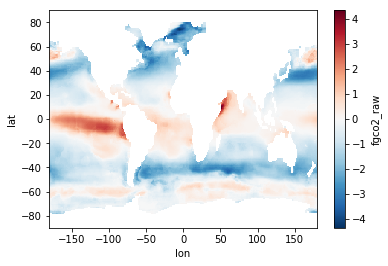

In [4]:
ds.fgco2_raw.mean(dim='time').plot()

In [5]:
area = xr.DataArray(np.empty((len(ds.lat),len(ds.lon))),
                    dims=('lat','lon'),coords=(ds.lat,ds.lon))
area.values = grid_tools.compute_grid_area(ds.lon.values,ds.lat.values)
area

total area = 5.1009974330982400e+14
check area = 5.1009969907076156e+14


<xarray.DataArray (lat: 180, lon: 360)>
array([[  1.078939e+08,   1.078925e+08,   1.078939e+08, ...,   1.078939e+08,
          1.078925e+08,   1.078939e+08],
       [  3.236818e+08,   3.236774e+08,   3.236818e+08, ...,   3.236818e+08,
          3.236774e+08,   3.236818e+08],
       [  5.393853e+08,   5.393779e+08,   5.393853e+08, ...,   5.393853e+08,
          5.393779e+08,   5.393853e+08],
       ..., 
       [  5.393853e+08,   5.393779e+08,   5.393853e+08, ...,   5.393853e+08,
          5.393779e+08,   5.393853e+08],
       [  3.236818e+08,   3.236774e+08,   3.236818e+08, ...,   3.236818e+08,
          3.236774e+08,   3.236818e+08],
       [  1.078939e+08,   1.078925e+08,   1.078939e+08, ...,   1.078939e+08,
          1.078925e+08,   1.078939e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...

Make a land mask

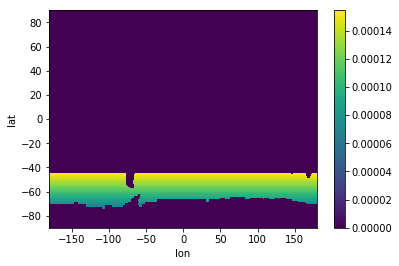

In [6]:
rmask = ds.seamask * area.where(ds.lat<-44.).fillna(0.)
total_area = rmask.sum()
rmask = rmask / total_area
np.testing.assert_approx_equal(rmask.sum(),1.)
rmask.plot()

compute weights for taking an annual mean from monthly values

In [46]:
dpm = xr.DataArray(xcal.get_dpm(ds.time.to_index()),coords=[ds.time])
wgt = dpm.groupby('time.year') / dpm.groupby('time.year').sum()
nyr = len(np.unique(wgt.year))

np.testing.assert_almost_equal(wgt.groupby('time.year').sum().values, np.ones(nyr))
print dpm.values

[ 31.  28.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  28.  31.
  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  29.  31.  30.  31.  30.
  31.  31.  30.  31.  30.  31.  31.  28.  31.  30.  31.  30.  31.  31.  30.
  31.  30.  31.  31.  28.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.
  31.  28.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  29.  31.
  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  28.  31.  30.  31.  30.
  31.  31.  30.  31.  30.  31.  31.  28.  31.  30.  31.  30.  31.  31.  30.
  31.  30.  31.  31.  28.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.
  31.  29.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  28.  31.
  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  28.  31.  30.  31.  30.
  31.  31.  30.  31.  30.  31.  31.  28.  31.  30.  31.  30.  31.  31.  30.
  31.  30.  31.  31.  29.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.
  31.  28.  31.  30.  31.  30.  31.  31.  30.  31.  30.  31.  31.  28.  31.
  30.  31.  

#### plot Southern Ocean timeseries

take weighted mean in space and make annual

In [8]:
molC_to_PgC = 12e-15
so = (ds * rmask).sum(dim=('lat','lon'))
for v in so.variables:
    if 'fgco2' in v:
        so[v] = so[v] * total_area * molC_to_PgC
        so[v].attrs['units'] = 'Pg C'
so

<xarray.Dataset>
Dimensions:         (bnds: 2, time: 408)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 1982-03-15 ...
Dimensions without coordinates: bnds
Data variables:
    spco2_raw       (time) float64 318.2 319.1 321.8 325.3 339.9 354.7 333.3 ...
    fgco2_raw       (time) float64 -0.5232 -0.6192 -0.5545 -0.3913 0.4873 ...
    spco2_smoothed  (time) float64 318.6 319.6 322.1 329.0 339.9 342.6 339.3 ...
    fgco2_smoothed  (time) float64 -0.5148 -0.5925 -0.5396 -0.09243 0.5085 ...
    sol             (time) float64 5.428e-05 5.364e-05 5.403e-05 5.517e-05 ...
    kw              (time) float64 1.473e+03 1.673e+03 1.861e+03 2.019e+03 ...
    aco2            (time) float64 330.2 330.5 331.2 331.6 330.8 331.8 331.8 ...
    ice             (time) float64 7.521 2.507 1.154 1.632 4.244 7.852 11.54 ...
    dco2_raw        (time) float64 -12.02 -11.36 -9.429 -6.244 9.106 22.9 ...
    dco2_smoothed   (time) float64 -11.59 -10.86 -9.175 -2.623 9.173 10.82 ...
 

In [9]:
soann = (so * wgt).groupby('time.year').sum(dim='time')
sostd = (so * wgt).groupby('time.year').std(dim='time')
soann

<xarray.Dataset>
Dimensions:         (bnds: 2, year: 34)
Coordinates:
  * year            (year) int64 1982 1983 1984 1985 1986 1987 1988 1989 ...
Dimensions without coordinates: bnds
Data variables:
    spco2_raw       (year) float64 329.7 330.3 330.5 331.1 332.1 332.9 334.4 ...
    fgco2_raw       (year) float64 -0.1264 -0.1745 -0.2787 -0.3095 -0.34 ...
    spco2_smoothed  (year) float64 329.5 330.3 330.4 331.1 332.1 332.9 334.4 ...
    fgco2_smoothed  (year) float64 -0.1249 -0.1784 -0.2805 -0.3062 -0.3383 ...
    sol             (year) float64 5.665e-05 5.615e-05 5.634e-05 5.639e-05 ...
    kw              (year) float64 1.736e+03 1.761e+03 1.685e+03 1.778e+03 ...
    aco2            (year) float64 331.7 333.2 334.9 335.8 337.3 338.7 340.9 ...
    ice             (year) float64 10.12 9.491 9.888 9.991 9.346 9.7 9.982 ...
    dco2_raw        (year) float64 -2.008 -2.876 -4.394 -4.678 -5.197 -5.762 ...
    dco2_smoothed   (year) float64 -2.123 -2.867 -4.428 -4.65 -5.174 -5.804 ...
   

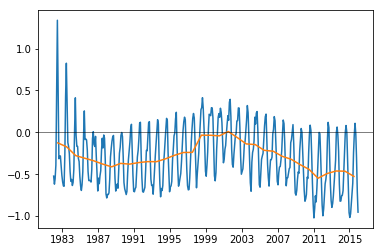

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(so.time,so.fgco2_raw)
ax.plot([datetime(y,7,1) for y in soann.year],soann.fgco2_raw)
ax.axhline(0.,linewidth=0.5,color='k')

In [59]:
ds = xr.open_dataset(files[1],drop_variables='date') # xarray gets hung up on the date var: omit
ds = ds.rename({'fgco2_clim':'CO2_FLUX','monthclim':'time'})
ds = ds.drop([k for k in ds.variables if k not in ['CO2_FLUX','area','lon','lat','time']])

dpm  = xcal.dpm['noleap']
eom = np.cumsum(dpm)
bom = np.concatenate((np.array([1]),eom[0:11]+1))
time = np.vstack((bom,eom)).mean(axis=0)
ds['time'] = xr.DataArray(time,dims=('time'))

ds['area'] = area
date = np.round(2000*10000 + np.arange(1,13,1) * 100. + xcal.dpm['noleap']/2.)
ds['date'] =  xr.DataArray(date,dims=('time'))
ds

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, time: 12)
Coordinates:
  * time      (time) float64 16.0 45.5 75.0 105.5 136.0 166.5 197.0 228.0 ...
  * lat       (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon       (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    CO2_FLUX  (time, lat, lon) float64 ...
    area      (lat, lon) float32 1.07894e+08 1.07892e+08 1.07894e+08 ...
    date      (time) float64 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 ...
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2016_clim
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2017-06-22

In [50]:
molC_to_PgC = 12e-15
so = (ds * rmask).sum(dim=('lat','lon'))
for v in so.variables:
    if 'CO2_FLUX' in v:
        so[v] = so[v] * total_area * molC_to_PgC
        so[v].attrs['units'] = 'Pg C'
so

<xarray.Dataset>
Dimensions:   (time: 12)
Dimensions without coordinates: time
Data variables:
    CO2_FLUX  (time) float64 -0.6143 -0.6143 -0.5182 -0.3916 -0.2195 -0.1022 ...
    area      float64 7.082e+09
    date      (time) float64 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 2e+07 ...

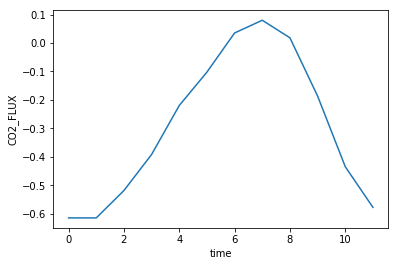

In [51]:
so.CO2_FLUX.plot()

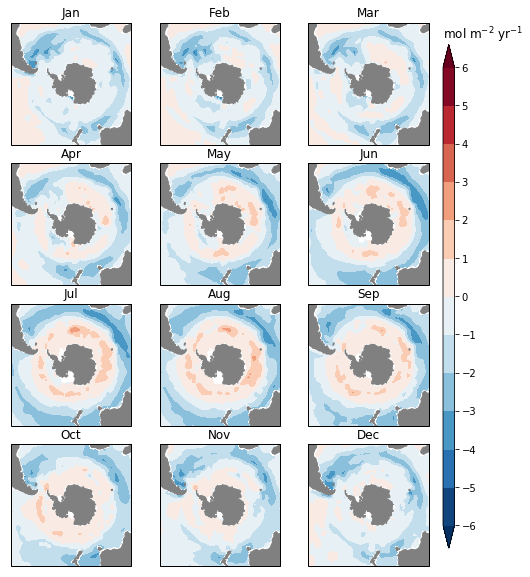

In [56]:
fig = plt.figure(figsize=(8,10))
gs = gridspec.GridSpec(4,3)
levels = np.arange(-6.,7.,1.)
for i in range(4):
    for j in range(3):
        ax = fig.add_subplot(gs[i,j],projection=ccrs.SouthPolarStereo())

        cf = ax.contourf(ds.lon,ds.lat,ds.CO2_FLUX.isel(time=i*3+j),
                         levels = levels,
                         cmap = 'RdBu_r',
                         extend='both',
                         transform=ccrs.PlateCarree())                             
        ax.set_extent([-180, 180, -90, -35], ccrs.PlateCarree())
        land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',edgecolor='face',facecolor='gray'))
        ax.set_title(xcal.month_sname[i*3+j])

cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(cf,cax=cbar_ax,
                  ticks = levels)
cbar_ax.set_title('mol m$^{-2}$ yr$^{-1}$',loc='left')
gs.update(hspace=0.15,wspace=0)

plt.savefig(os.path.join(diro['fig'],'flux-product-map-so-LGB17.pdf'))

In [60]:
ds.to_netcdf(flux_products.files['LGB17'])